In [48]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

# ----- Adapted Death Probability Functions for Daily Timesteps (CHANGE) -----

def old_age_death_probability(age_months, A=0.001, B=0.0001, C=0.2, dt=1.0):
    """
    Compute the death probability due solely to old age over a daily timestep.
    
    Parameters:
        age_months (float): Age of the rat in months.
        A, B, C (float): Model parameters (rates per month).
        dt (float): Timestep in days (default is 1 day).
        
    Returns:
        float: The probability of death due to old age over dt days.
    """
    # Convert dt (days) to equivalent fraction of a month.
    dt_months = dt / 30.0  
    mu_x = A + B * np.exp(C * age_months)
    prob_death = 1 - np.exp(-mu_x * dt_months)
    return prob_death

def age_multiplier(age_months, old_age_death_func, dt=1.0):
    """
    Compute a multiplier to adjust death probabilities for non-age-related causes,
    using a daily timestep.
    
    For very young rats (<1 month), a multiplier of 3.0 is used because they are more vulnerable.
    For adolescents (1-18 months), the multiplier is baseline (1.0).
    For older rats, the multiplier increases slightly based on the ratio of the current age death
    probability to that at 12 months.
    
    Parameters:
        age_months (float): Age of the rat in months.
        old_age_death_func (function): Function to compute old age death probability.
        dt (float): Timestep in days.
        
    Returns:
        float: The age-based multiplier.
    """
    if age_months <= 1:
        return 3.0
    elif age_months <= 18:
        return 1.0
    else:
        base = old_age_death_func(12, dt=dt)
        current = old_age_death_func(age_months, dt=dt)
        return 1.0 + 0.1 * ((current / base) - 1)

def radiation_death_probability(
    age_months,
    planet_flux,  # Multiple of Earth's flux
    old_age_death_func,
    earth_annual_dose=0.0024,  # Sv/year
    lethal_dose=7.0,           # Sv, approximate LD50 for rats
    dt=1.0                     # timestep in days
):
    """
    Calculate the death probability due to radiation exposure over a daily timestep.
    
    The function computes the daily dose by converting the monthly dose (derived from Earth's annual dose)
    to a daily value. This baseline probability is then adjusted by an age multiplier.
    
    Parameters:
        age_months (float): Age of the rat in months.
        planet_flux (float): Radiation flux relative to Earth.
        old_age_death_func (function): Function to compute old age death probability.
        earth_annual_dose (float): Earth's annual radiation dose (Sv/year).
        lethal_dose (float): Approximate LD50 for rats (in Sv).
        dt (float): Timestep in days.
        
    Returns:
        float: Final radiation death probability (capped at 1.0).
    """
    # Convert annual dose to monthly dose.
    earth_monthly_dose = earth_annual_dose / 12  
    monthly_dose = earth_monthly_dose * planet_flux
    # For dt days, dose scales as (dt/30)
    dose_for_dt = monthly_dose * (dt / 30.0)
    base_rad_prob = 1 - np.exp(-dose_for_dt / lethal_dose)
    multiplier = age_multiplier(age_months, old_age_death_func, dt=dt)
    final_rad_prob = base_rad_prob * multiplier
    return min(final_rad_prob, 1.0)

def gravity_death_probability(
    age_months,
    planet_gravity,
    old_age_death_func,
    dt=1.0,
    safe_range=(0.5, 2.0),
    k=10.0  # Sensitivity parameter
):
    """
    Calculate the death probability due to non-optimal gravity conditions over a daily timestep.
    
    If the planet's gravity is within the safe range, the base probability is 0.
    Otherwise, the probability increases with the deviation from the safe range.
    This base probability is then adjusted by an age multiplier.
    
    Parameters:
        age_months (float): Age of the rat in months.
        planet_gravity (float): Planet's gravity in Earth g units.
        old_age_death_func (function): Function to compute old age death probability.
        dt (float): Timestep in days.
        safe_range (tuple): Acceptable range of gravity (in g).
        k (float): Sensitivity parameter.
        
    Returns:
        float: Final gravity death probability (capped at 1.0).
    """
    if safe_range[0] <= planet_gravity <= safe_range[1]:
        base_gravity_prob = 0.0
    else:
        if planet_gravity < safe_range[0]:
            deviation = safe_range[0] - planet_gravity
        else:
            deviation = planet_gravity - safe_range[1]
        base_gravity_prob = 1 - np.exp(-deviation / k)
    multiplier = age_multiplier(age_months, old_age_death_func, dt=dt)
    final_grav_prob = base_gravity_prob * multiplier
    return min(final_grav_prob, 1.0)

def temperature_death_probability(
    age_months,
    planet_temperature_C,
    old_age_death_func,
    dt=1.0,
    T_optimal=20,     # Optimal temperature in °C
    T_threshold=10,   # Temperature threshold (°C) where risk starts increasing
    sigma=20.0        # Spread parameter (standard deviation) for the Gaussian tail
):
    """
    Calculates the death probability due to temperature over a daily timestep using a Gaussian tail model.
    
    If the absolute temperature difference from optimal is below T_threshold, the risk is 0.
    For differences above T_threshold, the risk increases as:
         1 - exp(-((temp_diff - T_threshold)^2)/(2*sigma^2))
    
    The result is then scaled by an age multiplier determined by the old_age_death_func.
    
    Parameters:
        age_months (float): The rat's age in months.
        planet_temperature_C (float): The planet's surface temperature in °C.
        old_age_death_func (function): Function to compute old-age death probability.
        dt (float): Timestep in days.
        T_optimal (float): Optimal temperature in °C.
        T_threshold (float): Temperature difference (°C) at which risk begins to increase.
        sigma (float): Spread parameter (standard deviation) for the Gaussian tail.
        
    Returns:
        float: Final probability of death due to temperature (capped at 1.0).
    """
    # Calculate the absolute temperature difference from optimal.
    temp_diff = abs(planet_temperature_C - T_optimal)
    if temp_diff <= T_threshold:
        base_temp_prob = 0.0
    else:
        base_temp_prob = 1 - np.exp(-((temp_diff - T_threshold) ** 2) / (2 * sigma ** 2))
    
    # Age multiplier (using daily dt)
    old_age_prob = old_age_death_func(age_months, dt=dt)
    adult_reference_prob = old_age_death_func(12, dt=dt)
    if age_months <= 1:
        age_multiplier_val = 3.0
    elif age_months <= 18:
        age_multiplier_val = 1.0
    else:
        age_multiplier_val = 1.0 + 0.1 * ((old_age_prob / adult_reference_prob) - 1)
    final_prob = base_temp_prob * age_multiplier_val
    return min(final_prob, 1.0)

def total_death_probability(age_months, planet_flux, planet_gravity, planet_temperature_C, old_age_death_func, dt=1.0):
    """
    Compute the overall death probability over a daily timestep by combining independent death probabilities.
    
    This function calculates the individual death probabilities due to old age, radiation,
    gravity, and temperature over dt days. Assuming these causes act independently,
    the overall survival probability is the product of their individual survival probabilities.
    
    Parameters:
        age_months (float): Age of the rat in months.
        planet_flux (float): Radiation flux relative to Earth.
        planet_gravity (float): Planet's gravity in g.
        planet_temperature_C (float): Ambient temperature in °C.
        old_age_death_func (function): Function to compute old age death probability.
        dt (float): Timestep in days.
        
    Returns:
        float: The overall death probability (capped at 1.0).
    """
    p_age = old_age_death_func(age_months, dt=dt)
    p_rad = radiation_death_probability(age_months, planet_flux, old_age_death_func, dt=dt)
    p_grav = gravity_death_probability(age_months, planet_gravity, old_age_death_func, dt=dt)
    p_temp = temperature_death_probability(age_months, planet_temperature_C, old_age_death_func, dt=dt)
    
    surv_age = 1 - p_age
    surv_rad = 1 - p_rad
    surv_grav = 1 - p_grav
    surv_temp = 1 - p_temp
    overall_survival = surv_age * surv_rad * surv_grav * surv_temp
    overall_death_prob = 1 - overall_survival

    return min(overall_death_prob, 1.0)

# ----- Exoplanet Class with Uncertainty Sampling -----
class Exoplanet:
    """
    Represents an exoplanet with various physical parameters.
    
    The class supports sampling uncertain parameters (mass, radius, orbit time, effective temperature)
    using provided uncertainties. It also computes the nominal surface gravity.
    """
    def __init__(self, name, mass, mass_unc, distance, distance_unit, radius, radius_unc,
                 orbit_time, orbit_time_unc, host_star, effective_temp,
                 effective_temp_unc_low, effective_temp_unc_high, radiation_flux, description):
        self.name = name
        self.mass = float(mass)
        self.mass_unc = float(mass_unc) if mass_unc not in ["NA", "", None] else 0.0
        self.distance = distance  # For reference only
        self.distance_unit = distance_unit  # For reference only
        self.radius = float(radius)
        self.radius_unc = float(radius_unc) if radius_unc not in ["NA", "", None] else 0.0
        self.orbit_time = float(orbit_time)
        self.orbit_time_unc = float(orbit_time_unc) if orbit_time_unc not in ["NA", "", None] else 0.0
        self.host_star = host_star  # For reference only
        self.effective_temp = float(effective_temp)
        self.effective_temp_unc_low = float(effective_temp_unc_low) if effective_temp_unc_low not in ["NA", "", None] else 0.0
        self.effective_temp_unc_high = float(effective_temp_unc_high) if effective_temp_unc_high not in ["NA", "", None] else 0.0
        self.radiation_flux = float(radiation_flux)
        self.description = description

    def sample_parameters(self):
        """
        Sample uncertain parameters using Gaussian distributions (for mass, radius, orbit time)
        and a triangular distribution for effective temperature if uncertainties are provided.
        
        Returns:
            dict: Sampled parameters.
        """
        sampled_mass = random.gauss(self.mass, self.mass_unc) if self.mass_unc > 0 else self.mass
        sampled_radius = random.gauss(self.radius, self.radius_unc) if self.radius_unc > 0 else self.radius
        sampled_orbit_time = random.gauss(self.orbit_time, self.orbit_time_unc) if self.orbit_time_unc > 0 else self.orbit_time
        if self.effective_temp_unc_low > 0 or self.effective_temp_unc_high > 0:
            lower_bound = self.effective_temp - self.effective_temp_unc_low
            upper_bound = self.effective_temp + self.effective_temp_unc_high
            sampled_effective_temp = random.triangular(lower_bound, upper_bound, self.effective_temp)
        else:
            sampled_effective_temp = self.effective_temp
        sampled_radiation_flux = self.radiation_flux

        return {
            "mass": sampled_mass,
            "radius": sampled_radius,
            "orbit_time": sampled_orbit_time,
            "effective_temp": sampled_effective_temp,
            "radiation_flux": sampled_radiation_flux
        }

    def gravity(self, mass=None, radius=None):
        """
        Calculate the nominal surface gravity in Earth g units.
        
        Parameters:
            mass (float): Optional mass to use (defaults to nominal mass).
            radius (float): Optional radius to use (defaults to nominal radius).
            
        Returns:
            float: Surface gravity (mass / radius^2).
        """
        if mass is None:
            mass = self.mass
        if radius is None:
            radius = self.radius
        return mass / (radius ** 2)

    def __str__(self):
        """
        Return a string representation of the exoplanet, including uncertainties and nominal gravity.
        """
        return (f"{self.name}: Mass={self.mass}±{self.mass_unc} Mₑ, Radius={self.radius}±{self.radius_unc} Rₑ, "
                f"Orbit={self.orbit_time}±{self.orbit_time_unc} days, Temp={self.effective_temp}K "
                f"(unc: -{self.effective_temp_unc_low}, +{self.effective_temp_unc_high}), "
                f"Radiation Flux={self.radiation_flux}, Gravity (nominal)={self.gravity():.2f} g\n"
                f"Description: {self.description}")

# ----- Rat Class with Biological Realism -----
class Rat:
    """
    Represents a rat with biological parameters and behavior.
    
    Each rat has energy reserves, a basal metabolic rate (BMR), and a set of traits (gravity and temperature tolerance).
    Rats can reproduce (with mutation) and are subject to death based on energy, old age, and environmental stressors.
    """
    def __init__(self, gravity_tolerance=1.0, temp_tolerance=1.0, age=60, weight=0.35, energy=0):
        self.gravity_tolerance = gravity_tolerance
        self.temp_tolerance = temp_tolerance
        self.age = age                # Age in days
        self.weight = weight          # Weight in kg
        self.energy = energy          # Energy used
        self.alive = True

        # Randomly assign gender ("M" for male, "F" for female)
        self.gender = random.choice(["M", "F"])
        
        # Reproduction-related attributes
        self.is_pregnant = False
        self.pregnancy_progress = 0.0  # Ranges from 0.0 to 1.0 over the gestation period
        self.expected_litter_size = None
        self.is_lactating = False
        self.lactation_timer = 0

    def basal_metabolic_rate(self):
        """
        Compute the basal metabolic rate (BMR) using an allometric scaling law. 
        Returns:
            float: BMR in kcal/day.
        """
        return 800 * (self.weight ** 0.75)

    def daily_energy_expenditure(self, planet_effective_temp, planet_gravity):
        """
        Compute the extra energy expenditure due to environmental stressors.
        
        This includes extra energy costs for deviations from Earth-like gravity and temperature,
        plus an additional cost if the rat is pregnant.
        
        Parameters:
            planet_effective_temp (float): Surface temperature in Kelvin.
            planet_gravity (float): Surface gravity in Earth g.
            
        Returns:
            float: Extra energy cost in kcal/day.
        """
        gravity_cost = abs(planet_gravity - self.gravity_tolerance) * 50
        ideal_temp = 288  # Ideal temperature (Earth average) in Kelvin
        temp_cost = abs(planet_effective_temp - ideal_temp) / 10
        pregnancy_cost = 5 if self.is_pregnant else 0
        lactating_cost = 20 if self.is_lactating else 0
        return gravity_cost + temp_cost + pregnancy_cost + lactating_cost

    def daily_activity(self, planet_effective_temp, planet_gravity, planet_flux):
        """
        Simulate one day of activity for the rat.
        
        This updates the rat's energy based on its energy gain (which depends on fitness)
        and energy expenditure (BMR plus environmental stress). It also updates the rat's age
        and checks for death using the combined death probability from old age, radiation,
        gravity, and temperature.
        
        Parameters:
            planet_effective_temp (float): Surface temperature in Kelvin.
            planet_gravity (float): Surface gravity in Earth g.
            planet_flux (float): Radiation flux relative to Earth.
        """
        if not self.alive:
            return

        # Calculate basal metabolic rate and extra energy expenditure.
        bmr = self.basal_metabolic_rate()
        extra_energy = self.daily_energy_expenditure(planet_effective_temp, planet_gravity)
        daily_energy_use = bmr + extra_energy

        # Compute fitness as a penalty based on deviation from ideal conditions.
        fitness_penalty = (abs(planet_gravity - self.gravity_tolerance) +
                           abs(planet_effective_temp - 288) / 100.0)
        fitness = max(0.1, 1 - fitness_penalty)
        daily_energy_gain = bmr * fitness

        # Compute net energy change and ensure it is not negative (unlimited food assumption).
        net_energy = daily_energy_gain - daily_energy_use
        if net_energy < 0:
            net_energy = 0

        self.energy += daily_energy_use
        self.age += 1  # Age increases by one day

        # Handle lactation timer for recently pregnant females.
        if self.is_lactating:
            self.lactation_timer -= 1
            if self.lactation_timer <= 0:
                self.is_lactating = False

        # Check for death.
        age_months = self.age / 30.0
        planet_temp_C = planet_effective_temp - 273.15
        death_prob = total_death_probability(age_months, planet_flux, planet_gravity, planet_temp_C, old_age_death_probability, dt=1)
        if random.random() < death_prob:
            self.alive = False

    def attempt_reproduction(self, potential_males):
        """
        Attempt reproduction for a female rat.
        
        If a mature female (age >= 60 days) has access to at least one mature male, she either
        initiates pregnancy (if not already pregnant) or, if already pregnant, her pregnancy
        advances gradually each day. When her pregnancy progress reaches 1 (i.e. after 21 days),
        she gives birth to her litter, which inherits slightly mutated tolerance traits.
        
        Parameters:
            potential_males (list): List of mature male rats.
            
        Returns:
            list: A list of offspring (empty if reproduction does not occur or pregnancy is in progress).
        """
        if self.gender != "F" or self.age < 60:
            return []
        
        # If already pregnant, update pregnancy progress.
        if self.is_pregnant:
            # Increment pregnancy progress assuming a 21-day gestation period.
            self.pregnancy_progress += 1 / 21.0
            if self.pregnancy_progress >= 1.0:
                # Gestation complete: give birth.
                offspring = []
                for _ in range(self.expected_litter_size):
                    mutation_factor = 0.05
                    new_gravity_tolerance = self.gravity_tolerance * random.uniform(1 - mutation_factor, 1 + mutation_factor)
                    new_temp_tolerance = self.temp_tolerance * random.uniform(1 - mutation_factor, 1 + mutation_factor)
                    baby = Rat(new_gravity_tolerance, new_temp_tolerance, age=0, weight=self.weight, energy=0)
                    offspring.append(baby)
                # Reset pregnancy state.
                self.is_pregnant = False
                self.pregnancy_progress = 0.0
                self.expected_litter_size = None
                # Initiate lactation.
                self.is_lactating = True
                self.lactation_timer = 21
                return offspring
            else:
                return []
        else:
            # Not currently pregnant; check for mating opportunities.
            if potential_males:
                # Initiate pregnancy.
                self.is_pregnant = True
                self.pregnancy_progress = 0.0
                self.expected_litter_size = random.randint(6, 12)
            return []


# ----- Function to Convert Effective to Surface Temperature -----
def effective_to_surface(effective_temp, method="ratio"):
    """
    Convert effective temperature to surface temperature assuming an Earth-like greenhouse effect.
    
    Two methods are available:
    - "ratio": Multiply effective temperature by 288/255 (Earth's ratio of surface to effective temperature).
    - "delta": Add 33 K to the effective temperature.
    
    Parameters:
        effective_temp (float): Effective temperature in Kelvin.
        method (str): Conversion method ("ratio" or "delta").
        
    Returns:
        float: Estimated surface temperature in Kelvin.
    """
    if method == "ratio":
        greenhouse_factor = 288 / 255
        return effective_temp * greenhouse_factor
    elif method == "delta":
        return effective_temp + 33
    else:
        raise ValueError("Unknown method. Choose 'ratio' or 'delta'.")

# ----- Simulation Function for a Given Exoplanet -----
def run_simulation_on_planet(planet: Exoplanet, simulation_days=365, initial_population_size=50):
    """
    Run the evolutionary simulation for a given exoplanet.
    
    This function samples the exoplanet's uncertain parameters, converts the effective temperature
    to a surface temperature, computes the surface gravity, and then simulates the daily activities
    (energy usage, reproduction, death) of a rat population over a number of days.
    
    Parameters:
        planet (Exoplanet): The exoplanet object.
        simulation_days (int): Number of simulation days (default: 5 years).
        initial_population_size (int): Starting population size.
        
    Returns:
        list: The final list of surviving rats.
    """
    # Sample uncertain parameters from the exoplanet.
    sampled = planet.sample_parameters()
    sampled_mass = sampled["mass"]
    sampled_radius = sampled["radius"]
    sampled_orbit_time = sampled["orbit_time"]
    sampled_effective_temp = sampled["effective_temp"]
    sampled_radiation_flux = sampled["radiation_flux"]
    
    # Convert effective temperature to surface temperature.
    sampled_surface_temp = effective_to_surface(sampled_effective_temp, method="ratio")
    # Calculate surface gravity using the sampled mass and radius.
    sampled_gravity = sampled_mass / (sampled_radius ** 2)
    
    # Print the sampled parameters.
    print(f"Running simulation for {planet.name} with sampled parameters:")
    print(f"  Mass = {sampled_mass:.3f} Mₑ, Radius = {sampled_radius:.3f} Rₑ, Orbit Time = {sampled_orbit_time:.3f} days")
    print(f"  Effective Temp = {sampled_effective_temp:.1f} K, Surface Temp = {sampled_surface_temp:.1f} K, Radiation Flux = {sampled_radiation_flux}, Gravity = {sampled_gravity:.2f} g\n")
    
    # Initialize the rat population.
    population = [Rat() for _ in range(initial_population_size)]

    dead_rat_list = []   # Use lists for efficiency
    day_list = []
    alive_rat_list = []
    energy_list = []

    # Run the simulation day-by-day.
    for day in range(simulation_days):
        dead_rat_counter = 0
        new_offspring = []
        # Filter out mature male rats (at least 60 days old) for reproduction.
        alive_males = [rat for rat in population if rat.alive and rat.gender == "M" and rat.age >= 60]
        
        for rat in population:
            if rat.alive:
                # Each rat performs its daily activities.
                rat.daily_activity(sampled_surface_temp, sampled_gravity, sampled_radiation_flux)
                # Females attempt reproduction if conditions are met.
                if rat.gender == "F":
                    offspring = rat.attempt_reproduction(alive_males)
                    if offspring:
                        new_offspring.extend(offspring)
            else:
                dead_rat_counter += 1

        # Add new offspring to the population.
        population.extend(new_offspring)
        # Calculate total energy used (optional, for printing).
        total_energy_used = sum(r.energy for r in population)
        # Remove dead rats from the population.
        population = [rat for rat in population if rat.alive]
        
        # Record statistics for the day.
        day_list.append(day)
        alive_rat_list.append(len(population))
        dead_rat_list.append(dead_rat_counter)
        energy_list.append(total_energy_used)

        if day % 30 == 0:
            avg_energy_used = sum(r.energy for r in population) / len(population) if population else 0
            print(f"Day {day} on {planet.name}: Population = {len(population)}, Average Energy Used = {avg_energy_used:.1f} kcal, Total Energy Used {total_energy_used:.1f} kcal")
        
        # Stop simulation if population = 0.
        if not population:
            break
        # Declare successful colony at 100,000 rats.
        if len(population) >= 100000:
            print("Colony successful (>100000 rats)")
            break

    # Print final average tolerance values if any rats survive.
    if population:
        avg_gravity_tolerance = sum(r.gravity_tolerance for r in population) / len(population)
        avg_temp_tolerance = sum(r.temp_tolerance for r in population) / len(population)
        print(f"\nAfter {simulation_days} days on {planet.name}:")
        print(f"  Average Gravity Tolerance: {avg_gravity_tolerance:.2f}")
        print(f"  Average Temperature Tolerance: {avg_temp_tolerance:.2f}")
    else:
        print(f"No survivors on {planet.name} after simulation.")

    # Optionally, convert lists to numpy arrays:
    day_array = np.array(day_list)
    alive_rat_counter = np.array(alive_rat_list)
    dead_rat_array = np.array(dead_rat_list)
    energy_array = np.array(energy_list)

    
    return day_array, alive_rat_counter, dead_rat_array, energy_array

# ----- Read CSV and Run Simulation for Each Exoplanet -----
exoplanets = []
with open('exoplanets copy.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        try:
            # Create an Exoplanet object for each row in the CSV.
            planet = Exoplanet(
                name=row["Name"],
                mass=row["Mass"],
                mass_unc=row["Mass_unc"],
                distance=row["Distance"],
                distance_unit=row["Distance_unit"],
                radius=row["Radius"],
                radius_unc=row["Radius_unc"],
                orbit_time=row["Orbit_Time"],
                orbit_time_unc=row["Orbit_Time_unc"],
                host_star=row["Host_Star"],
                effective_temp=row["Effective_Temp"],
                effective_temp_unc_low=row["Effective_Temp_unc_low"],
                effective_temp_unc_high=row["Effective_Temp_unc_high"],
                radiation_flux=row["Radiation_Flux"],
                description=row["Description"]
            )
            exoplanets.append(planet)
        except Exception as e:
            print(f"Error processing row: {row}\n{e}")





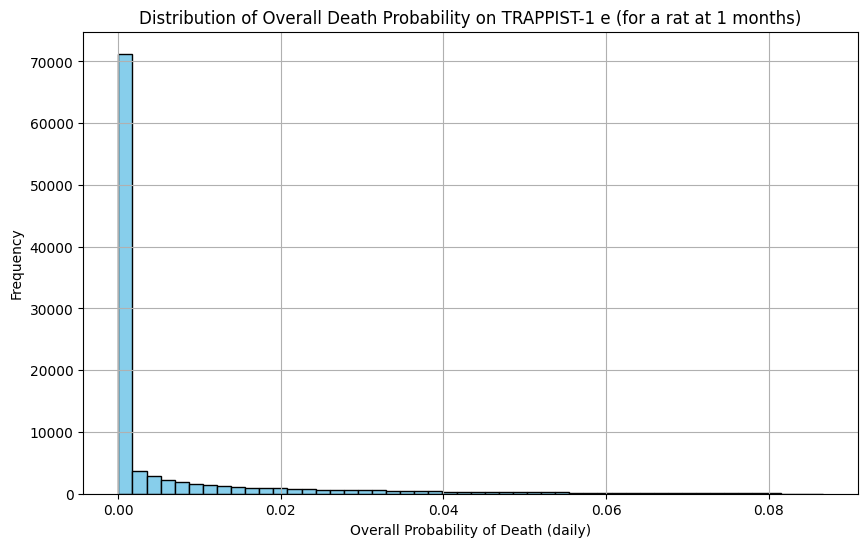

For TRAPPIST-1 e
Death Probability:0.00568910798164432 ± 0.012817675411403778



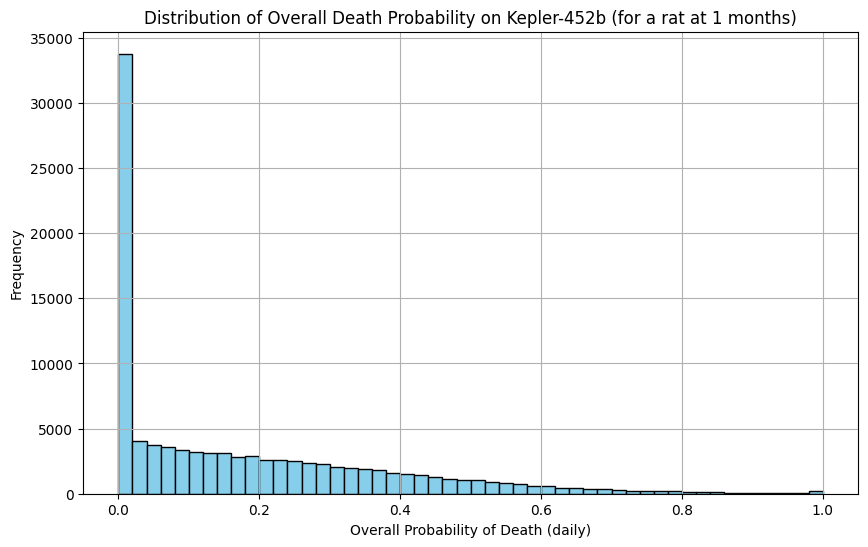

For Kepler-452b
Death Probability:0.17666191805809572 ± 0.20029957749598618



In [ ]:
# Choose one exoplanet (or loop over multiple if desired)
for planet in exoplanets:
    planet_name = planet.name
    num_iterations = 100000  # Number of Monte Carlo iterations
    death_probs = []

    # We'll use a fixed rat age (in months) for these calculations.
    rat_age_months = 12

    for i in range(num_iterations):
        # Sample uncertain parameters for the planet.
        sampled = planet.sample_parameters()
        sampled_mass = sampled["mass"]
        sampled_radius = sampled["radius"]
        sampled_effective_temp = sampled["effective_temp"]
        sampled_radiation_flux = sampled["radiation_flux"]

        # Convert effective temperature to surface temperature.
        # (You can choose your preferred method, here we use "ratio")
        sampled_surface_temp = effective_to_surface(sampled_effective_temp, method="ratio")
        
        # Calculate surface gravity using the sampled mass and radius.
        sampled_gravity = sampled_mass / (sampled_radius ** 2)
        
        # Convert surface temperature (in Kelvin) to Celsius for death probability.
        planet_temp_C = sampled_surface_temp - 273.15
        
        # Calculate the overall probability of death for a rat of the given age (in months)
        overall_prob = total_death_probability(
            age_months=rat_age_months,
            planet_flux=sampled_radiation_flux,
            planet_gravity=sampled_gravity,
            planet_temperature_C=planet_temp_C,
            old_age_death_func=old_age_death_probability,
            dt=1  # daily timestep
        )
        death_probs.append(overall_prob)

    death_probs = np.array(death_probs)

    # Plot a histogram of the overall probability of death.
    plt.figure(figsize=(10,6))
    plt.hist(death_probs, bins=50, color='skyblue', edgecolor='black')
    plt.xlabel("Overall Probability of Death (daily)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Overall Death Probability on {planet.name} (for a rat at {rat_age_months} months)")
    plt.grid(True)
    plt.show()


    mean_death_prob = np.mean(death_probs)
    std_death_prob = np.std(death_probs)
    print(f"For {planet_name}\nDeath Probability:{mean_death_prob} ± {std_death_prob}\n")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

max_days = 365  # Maximum simulation days (1 year)
number_of_simulations = 20  # Set the number of simulations per planet (adjust as needed)

planet_results = {}

# Run the simulation for each planet and pad arrays if simulation stops early.
for planet in exoplanets:
    planet_name = planet.name
    planet_results[planet_name] = {'days': None, 'alive': [], 'dead': [], 'energy': []}
    for sim in range(number_of_simulations):
        print("\n-------------------------------------------")
        print(planet)
        # run_simulation_on_planet returns day_array, alive_rat_counter, dead_rat_array
        day_array, alive_rat_counter, dead_rat_array, energy_array = run_simulation_on_planet(planet)
        
        # If the simulation finished early (< max_days), pad the arrays.
        current_length = len(day_array)
        if current_length < max_days:
            # Extend the day array to max_days.
            extra_days = np.arange(day_array[-1] + 1, max_days)
            day_array = np.concatenate([day_array, extra_days])
            
            # Pad alive and dead arrays with the final recorded value until max_days.
            final_alive = alive_rat_counter[-1]
            final_dead = dead_rat_array[-1]
            final_energy = energy_array[-1]
            pad_length = max_days - current_length
            alive_rat_counter = np.concatenate([alive_rat_counter, np.full(pad_length, final_alive)])
            dead_rat_array = np.concatenate([dead_rat_array, np.full(pad_length, final_dead)])
            final_energy = np.concatenate([energy_array, np.full(pad_length, final_energy)])
        
        # If this is the first simulation for the planet, store the (possibly padded) day_array.
        if planet_results[planet_name]['days'] is None:
            planet_results[planet_name]['days'] = day_array
        
        # Append the alive and dead counts arrays.
        planet_results[planet_name]['alive'].append(alive_rat_counter)
        planet_results[planet_name]['dead'].append(dead_rat_array)
        planet_results[planet_name]['energy'].append(energy_array)




-------------------------------------------
TRAPPIST-1 e: Mass=0.692±0.022 Mₑ, Radius=0.92±0.012 Rₑ, Orbit=6.101013±3.5e-05 days, Temp=251.3K (unc: -4.9, +4.9), Radiation Flux=1.0, Gravity (nominal)=0.82 g
Description: Among the most promising for liquid water, its modest mass and temperate conditions (assuming an atmosphere is retained) make it a strong candidate despite its ultracool host.
Running simulation for TRAPPIST-1 e with sampled parameters:
  Mass = 0.661 Mₑ, Radius = 0.928 Rₑ, Orbit Time = 6.101 days
  Effective Temp = 250.5 K, Surface Temp = 282.9 K, Radiation Flux = 1.0, Gravity = 0.77 g

Day 0 on TRAPPIST-1 e: Population = 50, Average Energy Used = 376.2 kcal, Total Energy Used 18810.0 kcal
Day 30 on TRAPPIST-1 e: Population = 323, Average Energy Used = 4697.7 kcal, Total Energy Used 1517363.3 kcal
Day 60 on TRAPPIST-1 e: Population = 607, Average Energy Used = 11519.9 kcal, Total Energy Used 6992549.8 kcal
Day 90 on TRAPPIST-1 e: Population = 1153, Average Energy Used 

In [ ]:
# Now plot the average number of alive rats per day with error bars (standard deviation) for each planet.
plt.figure(figsize=(12, 8))

for planet_name, results in planet_results.items():
    days = results['days']
    # Convert list of arrays to a 2D numpy array: shape = (number_of_simulations, number_of_days)
    alive_data = np.array(results['alive'])
    
    # Compute the average and standard deviation across simulations for each day.
    avg_alive = np.mean(alive_data, axis=0)
    std_alive = np.std(alive_data, axis=0)

    # Plot with error bars.
    plt.errorbar(days, avg_alive, yerr=std_alive, label=planet_name,
                 capsize=3, marker='o', linestyle='-')

plt.xlabel("Day")
plt.ylabel("Average Number of Alive Rats")
plt.title("Average Alive Rats per Day Across Exoplanets")
plt.legend(title="Planet")
plt.grid(True)
plt.show()

for planet_name, results in planet_results.items():
    days = results['days']
    # Convert list of arrays to a 2D numpy array: shape = (number_of_simulations, number_of_days)
    energy_data = np.array(results['energy'])
    avg_energy = np.mean(energy_data, axis=0)
    std_energy = np.std(energy_data, axis=0)

    # Plot with error bars.
    plt.errorbar(days, energy_data, yerr=std_energy, label=planet_name,
                 capsize=3, marker='o', linestyle='-')

plt.xlabel("Day")
plt.ylabel("Average Total Energy Consumed by the colony")
plt.title("Average Total Energy Consumed Across Exoplanets")
plt.legend(title="Planet")
plt.grid(True)
plt.show()


print(f"Total Energy Used by the colony: {avg_energy[-1]} ± {std_energy[-1]}")
